# Analyse des anomalies dans les données du Bitcoin et leur corrélation avec les événements historiques

Auteurs : Dmitry TERESHCHENKO & Arthur MOINE

In [1]:
%matplotlib inline 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
from datetime import datetime

### Introduction

Notre notebook sera basé sur l'article de recherche intitulé « Analyzing outliers activity from the time-series transaction pattern of Bitcoin blockchain », écrit par Rubaiyat Islam, Yoshi Fujiwara, Shinya Kawata et Hiwon Yoon en 2018. Notre objectif sera de reproduire et d'améliorer les méthodes utilisées dans l'article afin d'identifier plus efficacement les différentes anomalies présentes dans la blockchain. Nous représenterons graphiquement les motifs temporels des transactions de la cryptomonnaie, ainsi qu'analyserons statistiquement certaines données de la blockchain pour identifier les anomalies. Tout cela dans le but de démontrer que des événements historiques ont souvent des impacts significatifs sur la blockchain et ses acteurs.

### Dataset

Les données que nous utilisons pour cette analyse proviennent du challenge EGC 2024 (https://github.com/Yquetzal/DefiEGC2024). Deux types de données sont fournis pour synthétiser l'activité de la Blockchain sur une période de deux ans et demi, allant du 01/01/2015 au 30/06/2017 :
- Des séries temporelles décrivant l'activité globale de la Blockchain, ainsi que celle de 100 acteurs majeurs.
- Des réseaux de transactions (un par jour) décrivant les échanges entre un sous-ensemble d'acteurs majeurs.

Tout d'abord, nous allons extraire les statistiques globales des données des fichiers global.csv et external.csv, car ces fichiers sont les plus représentatifs de la blockchain dans sa totalité.

In [2]:
# extracting data
global_data = pd.read_csv('DefiEGC2024/timeseries/global.csv')
# removing unecessary data
global_data = global_data.drop(['year',	'month', 'day'], axis=1)
global_data = global_data.rename(columns={ global_data.columns[0]: "date" })
global_data['date'] = pd.to_datetime(global_data['date'])
global_data

,date,total_fee,total_received_satoshi,total_sent_satoshi,mean_fee_satoshi,mean_feeUSD,mean_fee_for100,nb_transactions,nb_payments,mean_nb_inputs,mean_nb_outputs,nb_mining,total_mining_satoshi,newly_created_coins,self_spent_satoshi,total_received,volume_without_self
0,2015-01-01,801373971,45473028339385,45058028339385,13609.829337,4.284054e+06,0.799999,58882,161194,2.595241,2.737577,166,415801373971,415000000000,2757774885900,45473028339385,42715253453485
1,2015-01-02,1159934218,73370568521080,72955568521080,14978.682808,4.732406e+06,0.778933,77439,257633,2.715557,3.326915,166,416159934218,415000000000,4316724676318,73370568521080,69053843844762
2,2015-01-03,1196476043,82635189454578,82220189454578,14304.385766,4.086009e+06,0.797419,83644,295618,2.781885,3.534240,166,416196476043,415000000000,5584584356557,82635189454578,77050605098021
3,2015-01-04,2159195328,115159442449532,114726942449532,25138.199015,6.619757e+06,0.899054,85893,280288,2.770133,3.263223,173,434659195328,432500000000,6554587956125,115159442449532,108604854493407
4,2015-01-05,1608443040,112439228285641,112051728285641,16955.609622,4.662858e+06,0.898594,94862,286552,2.954471,3.020725,155,389108443040,387500000000,5063695492444,112439228285641,107375532793197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,2017-06-26,35993152232,375012739382430,374842739382430,145080.443192,3.520181e+08,2.771988,248091,626222,2.565329,2.524163,136,205993152232,170000000000,14151200557043,375012739382430,360861538825387
908,2017-06-27,38384859820,287624055555912,287452805555912,142346.452989,3.601857e+08,3.044288,269658,747924,2.314862,2.773602,137,209634859820,171250000000,19821969138631,287624055555912,267802086417281
909,2017-06-28,38663204682,282904720130478,282717220130478,140744.451983,3.606988e+08,2.884102,274705,686018,2.471178,2.497290,150,226163204682,187500000000,10958737629631,282904720130478,271945982500847
910,2017-06-29,33153365173,317698686929569,317543686929569,144453.442667,3.669758e+08,2.760877,229509,570680,2.451838,2.486526,124,188153365173,155000000000,16909883109542,317698686929569,300788803820027


In [3]:
# load bitcoin price data
external_data = pd.read_csv('DefiEGC2024/timeseries/external.csv')
# drop first column
external_data.drop(columns=external_data.columns[0], axis=1, inplace=True)
# convert date type
external_data.date = pd.to_datetime(external_data.date)
external_data

,date,PriceUSD,HashRate
0,2015-01-02,315.942732,3.333450e+05
1,2015-01-03,285.647310,3.272842e+05
2,2015-01-04,263.334575,3.474869e+05
3,2015-01-05,275.003852,3.151626e+05
4,2015-01-06,287.549521,3.192031e+05
...,...,...,...
906,2017-06-26,2426.365051,5.023770e+06
907,2017-06-27,2530.345536,4.634604e+06
908,2017-06-28,2562.792264,5.554450e+06
909,2017-06-29,2540.443032,4.245439e+06


### Analyse générale

Nous allons maintenant récupérer les statistiques récapitulatives de nos données et extraire quelques informations importantes.

In [4]:
cols = ['nb_transactions', 'nb_mining', 'volume_without_self', 'total_mining_satoshi']

desc = global_data[cols].describe()

skl = []
ktl = []
for c in cols:
    skewness = global_data[c].skew()
    kurtosis = global_data[c].kurtosis()
    skl.append(skewness)
    ktl.append(kurtosis)

desc.loc['skewness'] = skl
desc.loc['kurtosis'] = ktl

desc

,nb_transactions,nb_mining,volume_without_self,total_mining_satoshi
count,912.000000,912.000000,9.120000e+02,9.120000e+02
mean,197946.012061,149.918860,2.152958e+14,3.097439e+11
std,72578.218717,13.904488,2.780223e+14,8.976175e+10
min,58882.000000,110.000000,4.054264e+13,1.501451e+11
25%,125391.000000,140.000000,1.149386e+14,2.097130e+11
50%,208736.500000,149.000000,1.753236e+14,3.453659e+11
75%,248158.250000,158.000000,2.401501e+14,3.826720e+11
max,375231.000000,212.000000,6.360983e+15,5.335712e+11
skewness,0.088450,0.419397,1.400964e+01,-2.227207e-01
kurtosis,-1.019487,0.575691,2.770360e+02,-1.443772e+00


Juste en observant les valeurs, on peut conclure que le nombre de transactions est assez grand pour mesurer la distribution statistique.

Pour le nombre de transactions par jour (nb_transactions), les valeurs moyennes (mean) et médianes (50%) sont presque identiques (197946 et 208736), ce qui signifie que le nombre de transactions est normalement distribué.

En moyenne, il y a 150 nouveaux blocs par jour (nb_mining), ce qui est très proche de la valeur théorique de 6 blocs/heure (6 * 24 = 144).

Le volume journalier montre des statistiques opposées (volume_without_self). Nous pouvons remarquer que la valeur médiane est inférieure à la moyenne (1.753236e+14 contre 2.152958e+14). Cette asymétrie est confirmée par le calcul de skewness. La skewness (asymétrie en français) est une mesure statistique qui permet de quantifier l'asymétrie d'une distribution de valeurs par rapport à la distribution normale.

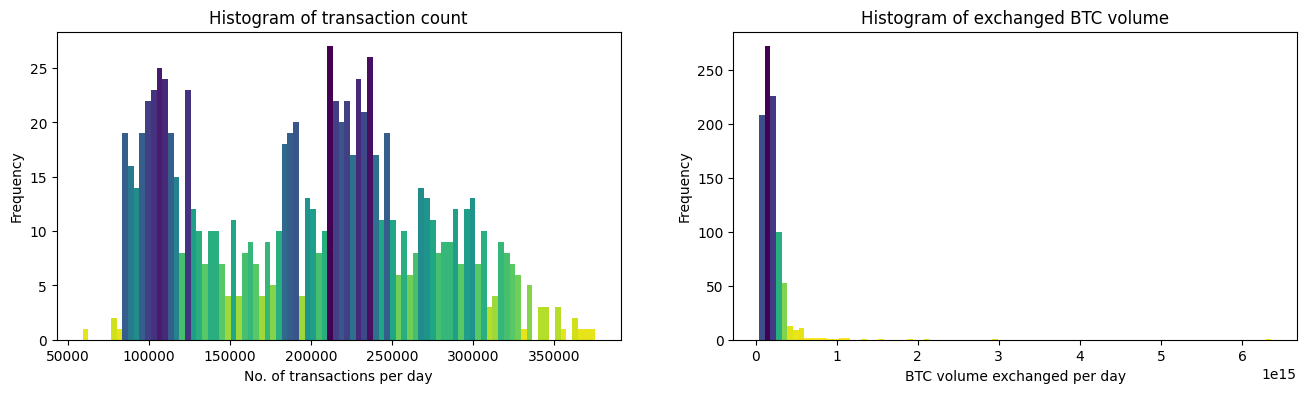

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,4))

n, bins, patches = ax1.hist(global_data['nb_transactions'], bins=90, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0)

n = n.astype('int')
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(1 - n[i]/max(n)))
ax1.set_title('Histogram of transaction count', fontsize=12)
ax1.set_xlabel('No. of transactions per day', fontsize=10)
ax1.set_ylabel('Frequency', fontsize=10)

n, bins, patches = ax2.hist(global_data['volume_without_self'], bins=90, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0)

n = n.astype('int')
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(1 - n[i]/max(n)))
ax2.set_title('Histogram of exchanged BTC volume', fontsize=12)
ax2.set_xlabel('BTC volume exchanged per day', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)

plt.show()

Les deux histogrammes démontrent bien que le nombre de transactions est fortement asymétrique, contrairement au volume de bitcoins échangés.

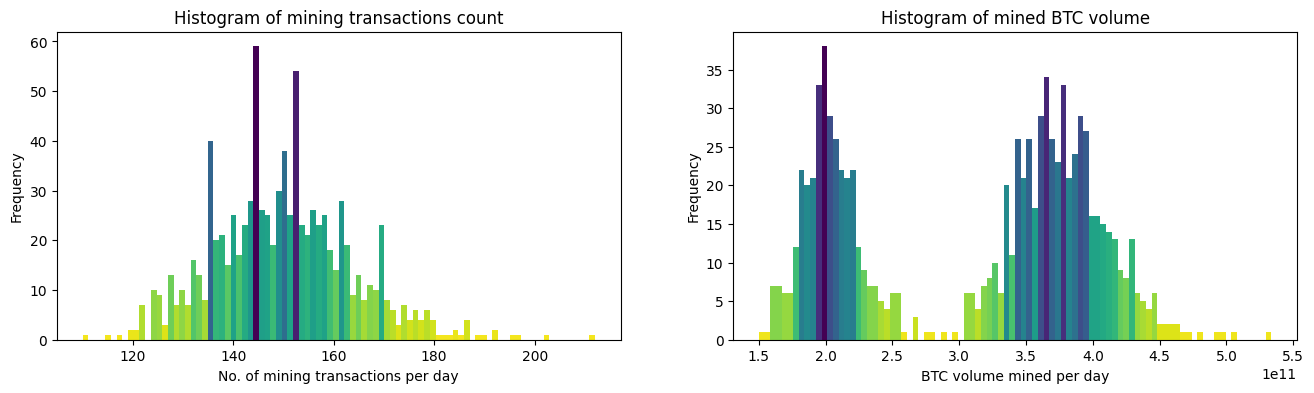

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,4))

n, bins, patches = ax1.hist(global_data['nb_mining'], bins=90, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0)

n = n.astype('int')
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(1 - n[i]/max(n)))
ax1.set_title('Histogram of mining transactions count', fontsize=12)
ax1.set_xlabel('No. of mining transactions per day', fontsize=10)
ax1.set_ylabel('Frequency', fontsize=10)

n, bins, patches = ax2.hist(global_data['total_mining_satoshi'], bins=90, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0)

n = n.astype('int')
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(1 - n[i]/max(n)))
ax2.set_title('Histogram of mined BTC volume', fontsize=12)
ax2.set_xlabel('BTC volume mined per day', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)

plt.show()

Le coefficient d'aplatissement (kurtosis en anglais) est une mesure statistique qui permet de quantifier l'aplatissement d'une distribution de valeurs par rapport à la distribution normale. Le coefficient d'aplatissement peut aider à déterminer si une distribution de données est similaire à une distribution normale, et à identifier les écarts par rapport à une distribution normale. C'est une mesure utile pour l'analyse de données et la modélisation statistique.

Le volume de bitcoins minés par jour (total_mining_satoshi) montre également un skewness et un kurtosis importants, ce qui nous conduit à observer les données à l'échelle logarithmique.

### Le rendement logarithmique et la fonction d'auto-corrélation

Le log return, ou rendement logarithmique en français, est une mesure couramment utilisée en finance pour évaluer la performance d'un actif financier tel que des actions, des obligations ou des devises. Le log return mesure le taux de variation des prix d'un actif financier sur une période donnée en utilisant le logarithme naturel des prix plutôt que les prix eux-mêmes. Le calcul du log return permet de normaliser les données et de les rendre plus facilement comparables, en prenant en compte les variations relatives de prix plutôt que les variations absolues.

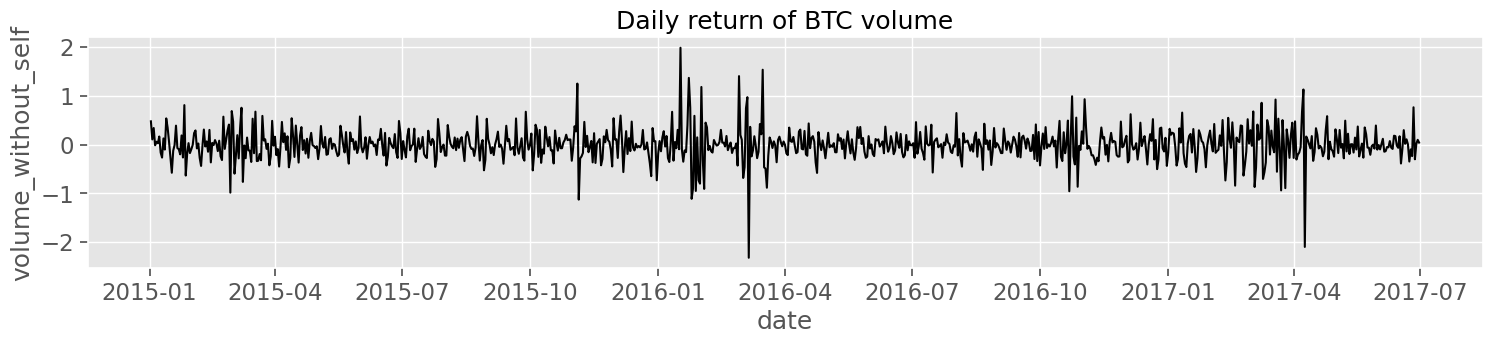

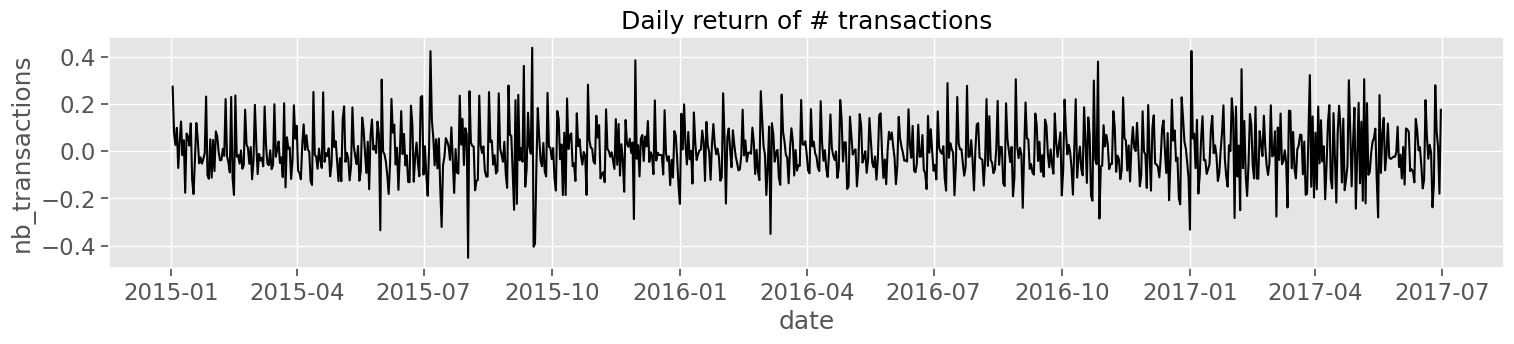

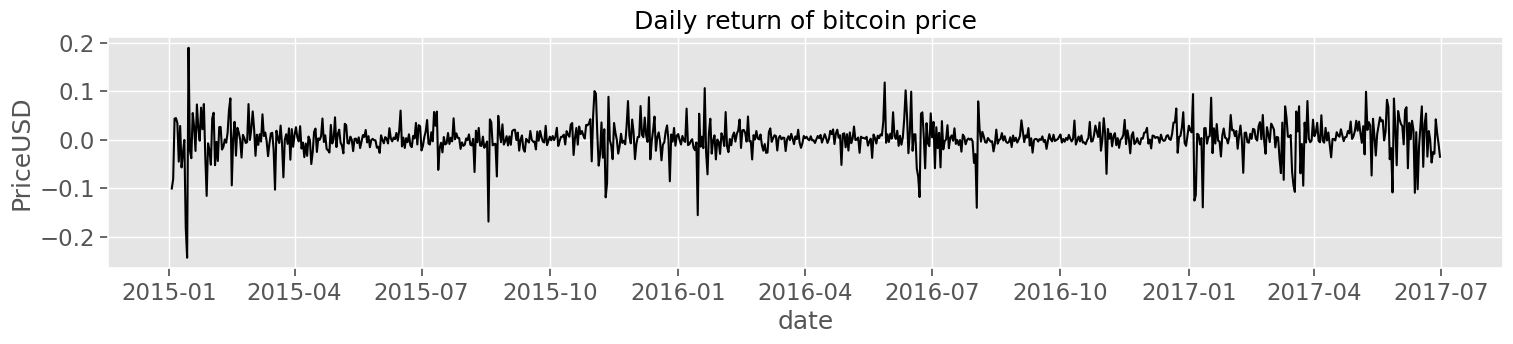

In [7]:
plt.style.use('ggplot')
sns.set_context('notebook', font_scale=1.5, rc={"lines.linewidth": 1.5})

plt.subplots(figsize=(18, 3))
sns.lineplot(x='date', y=np.log(global_data.volume_without_self).diff(1).shift(0), data=global_data, color='black')
plt.title('Daily return of BTC volume')

plt.subplots(figsize=(18, 3))
sns.lineplot(x='date', y=np.log(global_data.nb_transactions).diff(1).shift(0), data=global_data, color='black')
plt.title('Daily return of # transactions')

plt.subplots(figsize=(18, 3))
sns.lineplot(x='date', y=np.log(external_data.PriceUSD).diff(1).shift(0), data=external_data, color='black')
plt.title('Daily return of bitcoin price')

plt.show()

On identifie plusieurs points de rupture, qu'on peut associer aux différents événements importants de l'actualité :
- Pour le volume en mai 2016 : Craig Wright se présente comme le vrai Satoshi.
- Pour le volume en avril 2017 : Le Japon reconnaît le Bitcoin comme monnaie légale.
- Pour le nombre de transactions en août 2015 : les développeurs de Bitcoin sortent Bitcoin XT.
- Pour le nombre de transactions en septembre 2015 : Bitcoin est classé comme une marchandise aux États-Unis.
- Pour le nombre de transactions en janvier 2017 : Bitcoin dépasse les 1000$.
- Pour le prix en janvier 2015 : cyberattaque de Bitstamp.

Nous allons maintenant afficher les fonctions d'autocorrélation pour ces trois données. La fonction d'autocorrélation est une mesure statistique qui permet d'évaluer le degré de corrélation linéaire entre les valeurs d'une série temporelle et ses propres valeurs retardées (décalées dans le temps). Cette métrique est utilisée pour déterminer si les valeurs d'une série temporelle dépendent les unes des autres ou non. Elle permet également d'identifier les patterns récurrents ou les cycles présents dans la série temporelle.

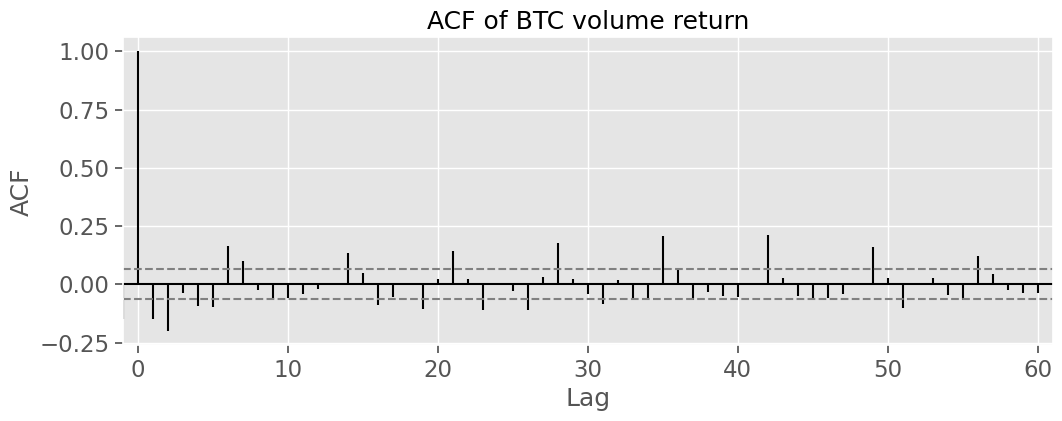

In [8]:
data = np.log(global_data.volume_without_self).diff(1).shift(0).to_numpy()
data[0] = 0

plt.subplots(figsize=(12, 4))

# adding plot annotations
plt.title('ACF of BTC volume return')
plt.ylabel('ACF')
plt.xlabel('Lag')
 
# plotting the Autocorrelation plot
plt.acorr(data, maxlags = 60, usevlines= True, color='black')
plt.xlim([-1, 61])

# adding the dotted line for 95% confidence interval
ci = 1.96 / np.sqrt(len(data))
plt.axhline(y=ci, linestyle='--', color='gray')
plt.axhline(y=-ci, linestyle='--', color='gray')
 
# displaying the plot
plt.grid(True)
 
plt.show()

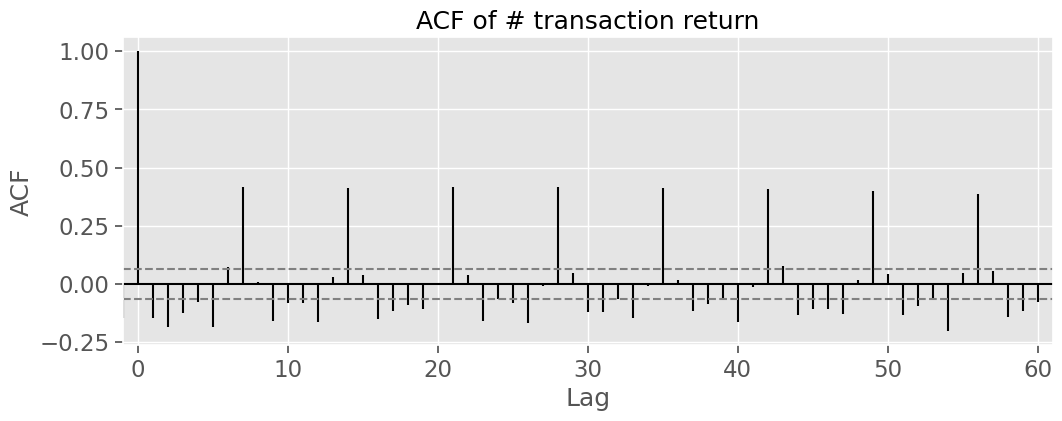

In [9]:
data = np.log(global_data.nb_transactions).diff(1).shift(0).to_numpy()
data[0] = 0

plt.subplots(figsize=(12, 4))

# adding plot annotations
plt.title('ACF of # transaction return')
plt.ylabel('ACF')
plt.xlabel('Lag')
 
# plotting the Autocorrelation plot
plt.acorr(data, maxlags = 60, usevlines= True, color='black')
plt.xlim([-1, 61])

# adding the dotted line for 95% confidence interval
ci = 1.96 / np.sqrt(len(data))
plt.axhline(y=ci, linestyle='--', color='gray')
plt.axhline(y=-ci, linestyle='--', color='gray')
 
# displaying the plot
plt.grid(True)
 
plt.show()

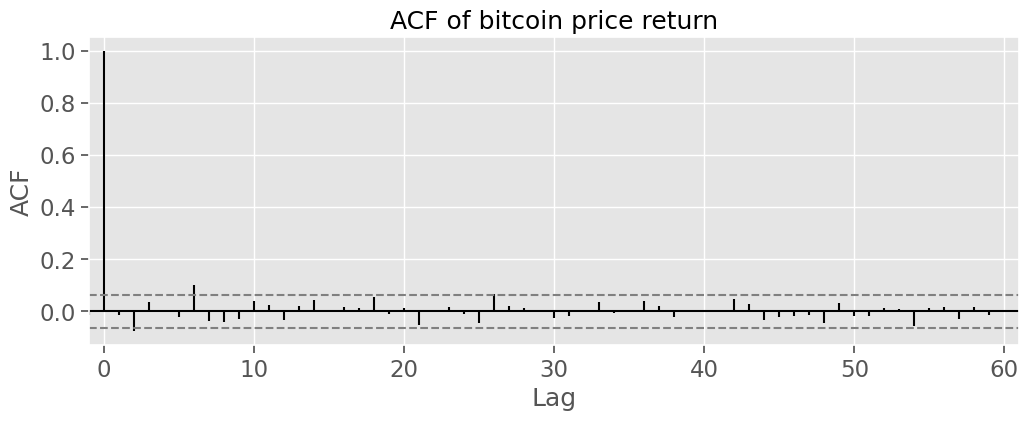

In [10]:
data = np.log(external_data.PriceUSD).diff(1).shift(0).to_numpy()
data[0] = 0

plt.subplots(figsize=(12, 4))

# adding plot annotations
plt.title('ACF of bitcoin price return')
plt.ylabel('ACF')
plt.xlabel('Lag')
 
# plotting the Autocorrelation plot
plt.acorr(data, maxlags = 60, usevlines= True, color='black')
plt.xlim([-1, 61])

# adding the dotted line for 95% confidence interval
ci = 1.96 / np.sqrt(len(data))
plt.axhline(y=ci, linestyle='--', color='gray')
plt.axhline(y=-ci, linestyle='--', color='gray')
 
# displaying the plot
plt.grid(True)
 
plt.show()

La ligne pointillée représente l'intervalle de confiance à 95 %.

Après une courte observation, on remarque rapidement que la série de données pour le volume et le nombre de transactions présente des motifs cycliques hebdomadaires, tandis que l'ACF (fonction d'autocorrélation) du prix ne présente pas de motifs distincts. Cette observation est cohérente car si le prix du bitcoin était facilement prévisible, cela aurait un impact important sur le marché.

### Vue générale de l'évolution du Bitcoin

Cette partie de l'analyse consiste à mettre en relation différentes données du bitcoin afin d'avoir une vue globale de 2015 à 2017, et ainsi identifier les liens entre celles ci.

<Figure size 1400x700 with 0 Axes>

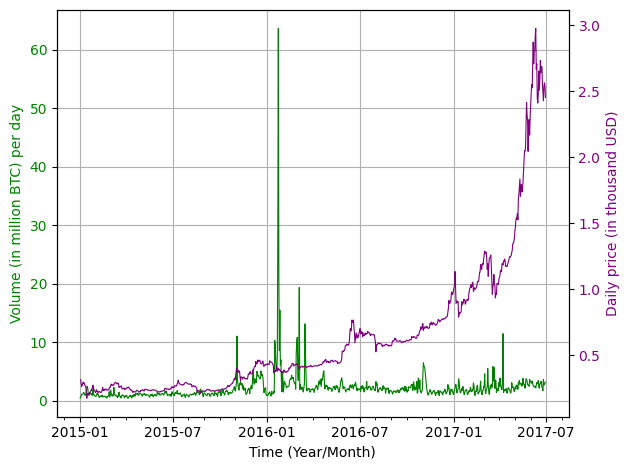

In [11]:
plt.figure(figsize=(14,7))

plt.style.use('default')

fig, ax1 = plt.subplots()

color = 'green'
ax1.set_xlabel('Time (Year/Month)')
ax1.set_ylabel('Volume (in million BTC) per day', color=color)
ax1.plot(global_data['date'], global_data['volume_without_self'] / 100000000000000, linewidth=0.8, color=color, label='Transactions')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax1.xaxis.set_minor_locator(mdates.MonthLocator())

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'purple'
ax2.set_ylabel('Daily price (in thousand USD)', color=color)  # we already handled the x-label with ax1
ax2.plot(external_data['date'], external_data['PriceUSD'] / 1000, linewidth=0.8, color=color, label='volume')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

Le premier graphique présente les données en série temporelle du volume de BTC et prix journalier. Cela permet d'observer comment le volume et le prix du Bitcoin ont évolué au fil du temps.

On constate que le prix du bitcoin a augmenté de façon exponentielle depuis 2015, avec des pics irréguliers montrant sa volatilité.

<Figure size 1400x700 with 0 Axes>

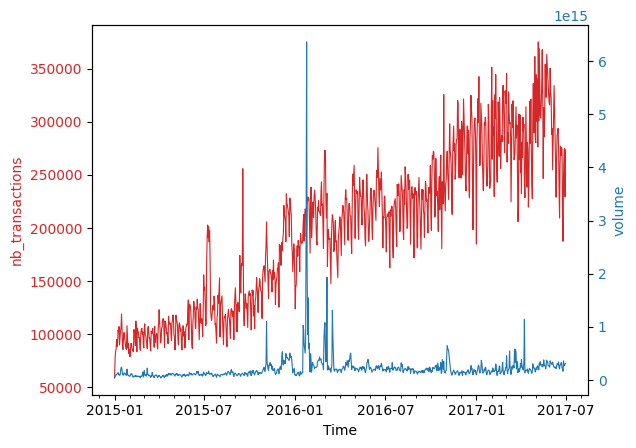

In [13]:
plt.figure(figsize=(14,7))

plt.style.use('default')

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('nb_transactions', color=color)
ax1.plot(global_data['date'], global_data['nb_transactions'], linewidth=0.8, color=color, label='Transactions')
ax1.tick_params(axis='y', labelcolor=color)


ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax1.xaxis.set_minor_locator(mdates.MonthLocator())

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('volume', color=color)  # we already handled the x-label with ax1
ax2.plot(global_data['date'], global_data['volume_without_self'],  linewidth=0.8, color=color, label='volume')
ax2.tick_params(axis='y', labelcolor=color)

Ici, nous montrons l'évolution du volume journalier comparé aux nombre de transactions, difficilement interprétable, on applique donc la fonction log aux série temporelles afin de normaliser les valeurs.

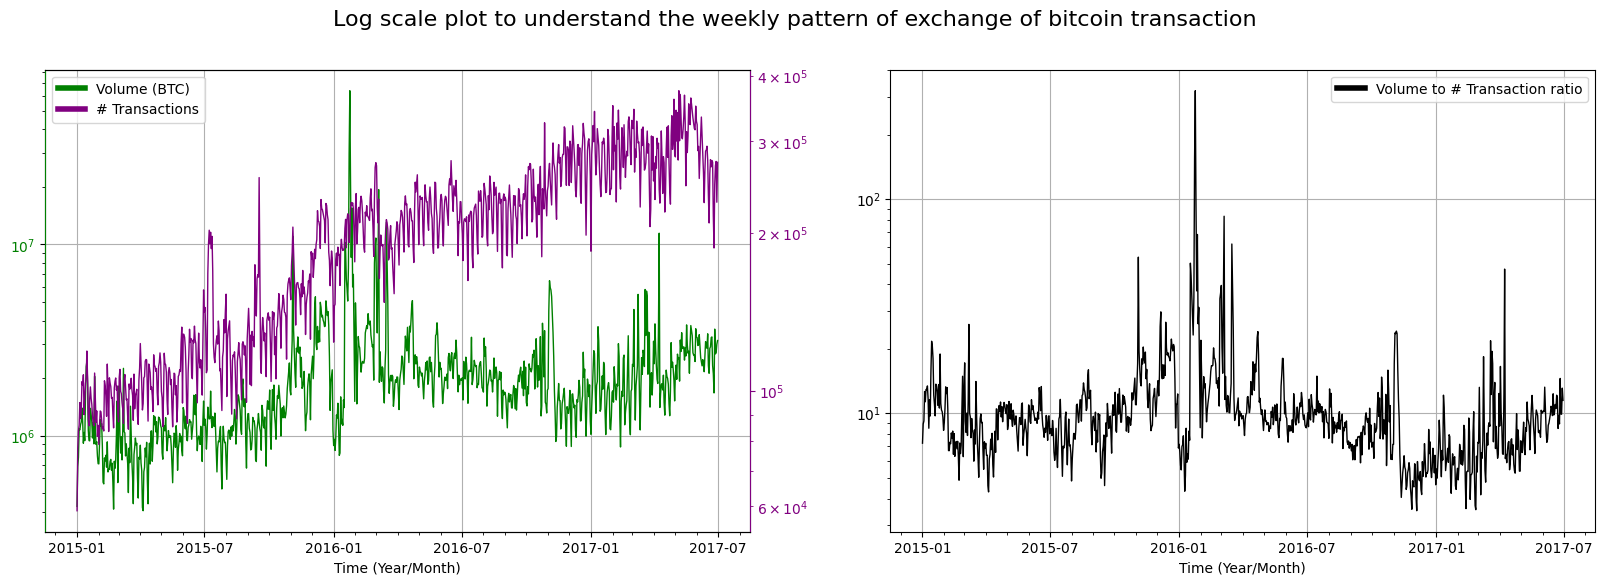

In [12]:
plt.style.use('default')
global_data['date'] = pd.to_datetime(global_data['date'])

fig, ax = plt.subplots(1,2, figsize=(20, 6))
fig.suptitle('Log scale plot to understand the weekly pattern of exchange of bitcoin transaction', fontsize=16)

ax1 = ax[0]
ax3 = ax[1]

color = 'green'
ax1.set_yscale('log')
ax1.set_xlabel('Time (Year/Month)')
ax1.plot(global_data['date'], global_data['volume_without_self'] / 100000000, color=color, label='Volume (BTC)', lw=1)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax1.xaxis.set_minor_locator(mdates.MonthLocator())

ax2 = ax1.twinx()
color='purple'
ax2.set_yscale('log')
ax2.plot(global_data['date'], global_data['nb_transactions'], color=color, label='# Transactions', lw=1)
ax2.tick_params(axis='y', colors='purple', which='both')
custom_lines = [Line2D([0], [0], color='green', lw=4), Line2D([0], [0], color='purple', lw=4)]
ax2.legend(custom_lines, ['Volume (BTC)', '# Transactions'])
ax2.spines['right'].set_color('purple')
ax2.spines['left'].set_color('green')

ax3.plot(global_data['date'], (global_data['volume_without_self'] / 100000000) / global_data['nb_transactions'], color='black', label='Volume to # Transaction ratio', lw=1)
ax3.set_yscale('log')
ax3.set_xlabel('Time (Year/Month)')
ax3.grid(True)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax3.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax3.xaxis.set_minor_locator(mdates.MonthLocator())
custom_line = Line2D([0], [0], color='black', lw=4)
ax3.legend([custom_line], ['Volume to # Transaction ratio'])

plt.show()

Ce second graphe montre le volume comparé aux transactions circulant quotidiennement à une échelle logarithmique, avec en parallele le ratio volume/transaction.

Appliquer une fonction log sur une série temporelle à forte croissance peut servir à stabiliser la variance, linéariser les données, réduire les effets d'échelle et mettre en évidence les taux de croissance relatifs. Cela peut faciliter l'analyse et l'interprétation des données en rendant les tendances et les motifs sous-jacents plus clairs.

Ici, cela nous permet donc de mieux identifier les patterns hebdomadaires(pics réguliers)

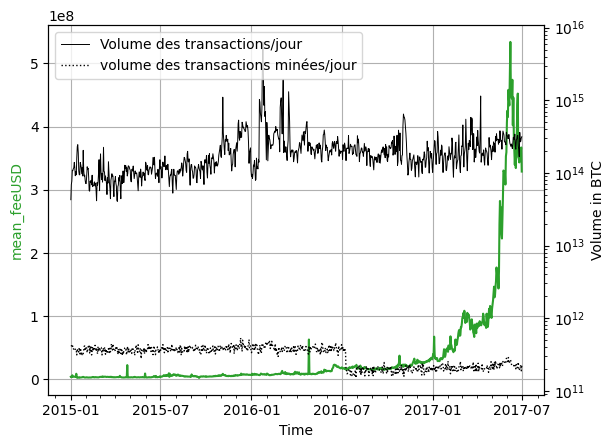

In [29]:


plt.style.use('default')
global_data['date'] = pd.to_datetime(global_data['date'])

fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('Time')
ax1.set_ylabel('mean_feeUSD', color=color)
ax1.plot(global_data['date'], global_data['mean_feeUSD'], color=color, label='Prix journalier moyen en USD')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax1.xaxis.set_minor_locator(mdates.MonthLocator())

ax1.grid(True)

ax2 = ax1.twinx()

ax2.set_ylabel('Volume in BTC')
ax2.plot(global_data['date'],global_data['volume_without_self'], color='k', linewidth=0.7, label='Volume des transactions/jour'),
ax2.plot(global_data['date'],global_data['total_mining_satoshi'], color='k', linestyle=':',  linewidth=1, label='volume des transactions minées/jour'),

plt.yscale('log')

plt.legend(loc='upper left')

plt.show()

Ce dernier graphe permet de visualiser le volume des transactions et de transactions minées par jour comparé au prix moyen journalier.

On observe que le volume de transactions minées est relativement stable tout au  long de la série temporelle.

### Patterns hebdomadaires du volume et des transactions de BTC

Les patterns hebdomadaires observés sont maintenant mis en évidence dans cette partie.

In [15]:
from scipy.stats import sem

global_data['day_of_week'] = global_data['date'].dt.dayofweek

grouped_g_d1 = global_data.groupby(['day_of_week', pd.Grouper(key='date', freq='W-MON')])['nb_transactions'].sum().reset_index()
grouped_g_d2 = global_data.groupby(['day_of_week', pd.Grouper(key='date', freq='W-MON')])['volume_without_self'].sum().reset_index()

# Calculate the logarithm of transaction_count and daily volume
grouped_g_d1['log_transaction_count'] = np.log(grouped_g_d1['nb_transactions'])
grouped_g_d2['log_volume'] = np.log(grouped_g_d2['volume_without_self'])

# Calculate the average of log_transaction_count and log_volume for each day of the week
avg_log_transaction_count = grouped_g_d1.groupby('day_of_week')['log_transaction_count'].mean()
avg_log_volume = grouped_g_d2.groupby('day_of_week')['log_volume'].mean()

# Calculate the standard error of the mean (SEM) for each day of the week
sem_log_transaction_count = grouped_g_d1.groupby('day_of_week')['log_transaction_count'].apply(sem)
sem_log_volume = grouped_g_d2.groupby('day_of_week')['log_volume'].apply(sem)

# Map day_of_week integers to day names
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sem_log_transaction_count.index = day_names
avg_log_transaction_count.index = day_names

sem_log_volume.index = day_names
avg_log_volume.index = day_names


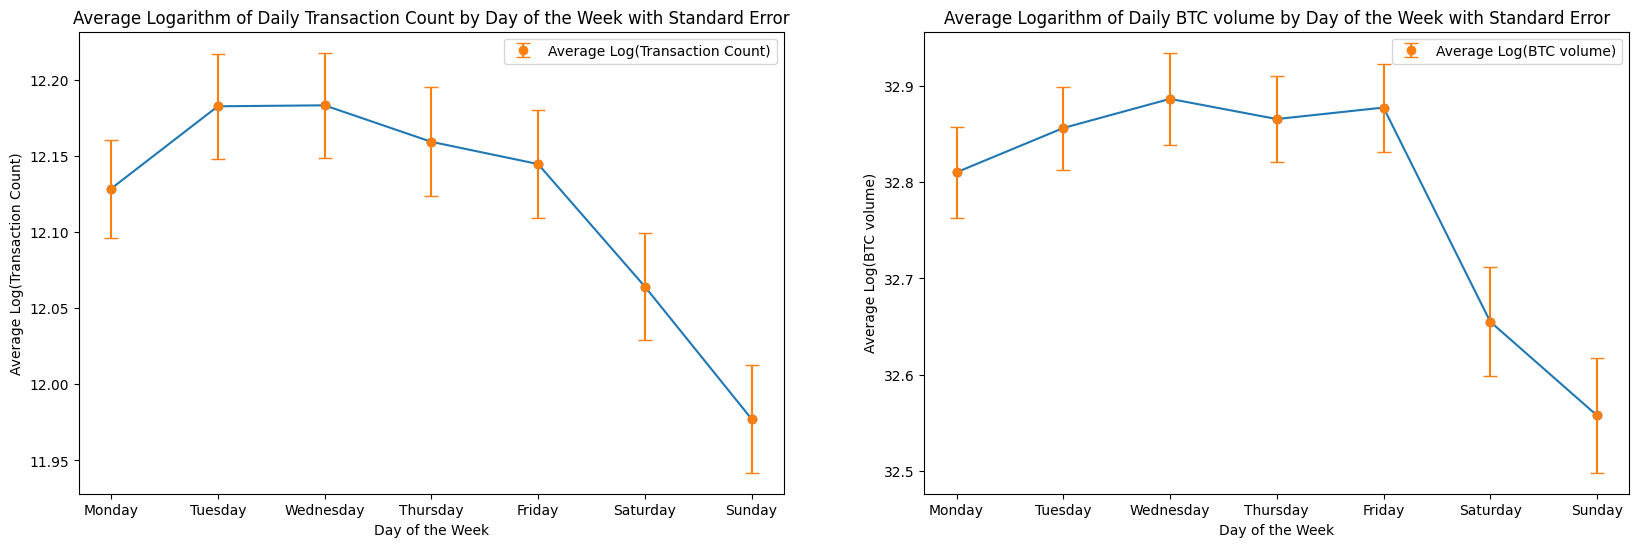

In [16]:

# Create a bar chart with error bars representing SEM
fig, ax = plt.subplots(1,2, figsize=(20, 6))
ax1 = ax[0]
ax2 = ax[1]


ax1.plot(avg_log_transaction_count.index, avg_log_transaction_count.values, marker='o')
ax1.errorbar(avg_log_transaction_count.index, avg_log_transaction_count.values, yerr=sem_log_transaction_count.values,  fmt='o', capsize=5, label='Average Log(Transaction Count)')
ax1.set_xlabel('Day of the Week')
ax1.set_ylabel('Average Log(Transaction Count)')
ax1.set_title('Average Logarithm of Daily Transaction Count by Day of the Week with Standard Error')
ax1.legend()

ax2.plot(avg_log_volume.index, avg_log_volume.values, marker='o')
ax2.errorbar(avg_log_volume.index, avg_log_volume.values, yerr=sem_log_volume.values, fmt='o', capsize=5, label='Average Log(BTC volume)')
ax2.set_xlabel('Day of the Week')
ax2.set_ylabel('Average Log(BTC volume)')
ax2.set_title('Average Logarithm of Daily BTC volume by Day of the Week with Standard Error')
ax2.legend()
plt.show()

Tout d'abord, nous avons segmenté les données pour chaque jour de la semaine puis calculé les moyennes et les erreurs standards, c'est à dire l'écart-type divisé par la racine carrée du nombre de données dans chaque collection. 
On observe que le niveau de volume et de transactions est plus élevé en semaine qu'en week-end.
C'est un détail qui n'était pas visible sur les graphes précédents.

Ensuite, nous avons réalisé un périodogramme permettant d'identifier la fréquence des patterns.
On a d'abord appliqué une atténuation de 10% des valeurs de début et fin de la série temporelle, ce qui permet de réduire leur impact sur l'analyse statistique. Cela vise à lisser les valeurs extrêmes aux extrémités de la série de données afin d'améliorer la fiabilité et la robustesse des résultats.

Enfin, nous avons appliqué un lissage de Daniell, cela consiste à prendre des moyennes mobiles successives de différentes longueurs pour lisser les fluctuations et les bruits dans les données. Plus précisément, cette méthode utilise des moyennes mobiles simples de longueurs 6 et 12 pour lisser les données temporelles.

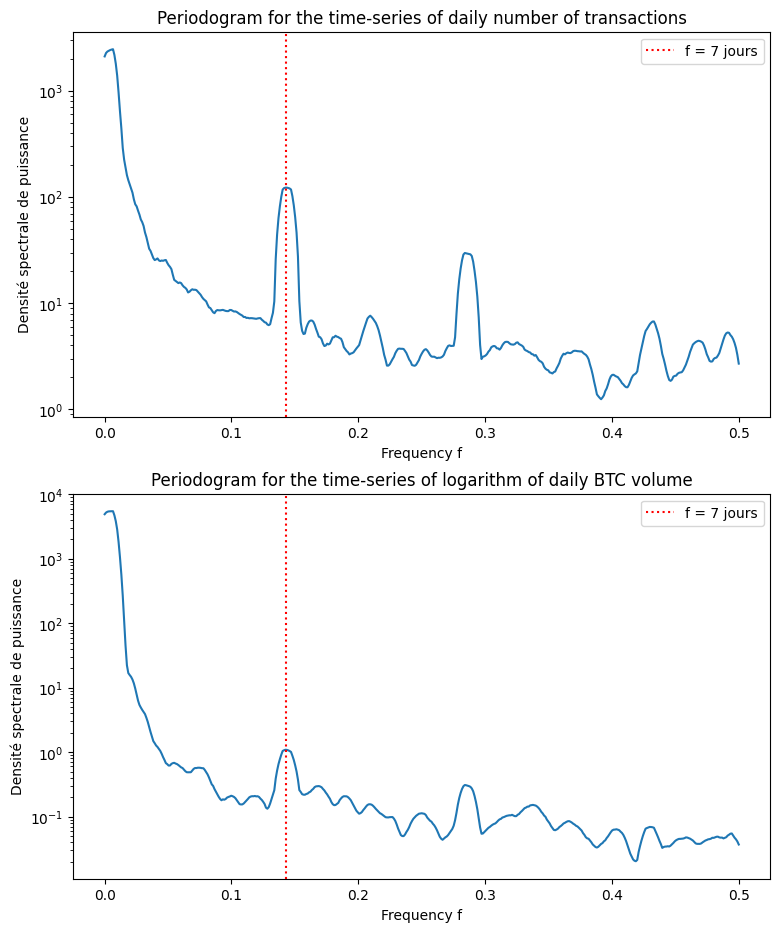

In [17]:
from scipy import signal

x_transac = global_data['nb_transactions'].values
x_volume = np.log(global_data['volume_without_self'].values)

fs = 1

# Define the tapering window
n_taper = int(len(x_transac) * 0.1)
taper_window = np.concatenate([np.linspace(0, 1, n_taper, endpoint=False),
                                np.ones(len(x_transac) - 2*n_taper),
                                np.linspace(1, 0, n_taper, endpoint=False)])

# Apply the tapering window to the data
x_t_tapered = x_transac * taper_window
x_v_tapered = x_volume * taper_window

# calculate periodogram
f_transac, Pxx_transac = signal.periodogram(x_t_tapered, window='boxcar', fs=fs, detrend='linear')
f_volume, Pxx_volume = signal.periodogram(x_v_tapered, window='boxcar', fs=fs, detrend='linear')

Pxx_transac[0] = Pxx_transac[1]
Pxx_volume[0] = Pxx_volume[1]

# Daniell smoothing
w1 = np.ones(6)/6
w2 = np.ones(12)/12
Pxx_t_smoothed = np.convolve(np.convolve(Pxx_transac, w1, mode='same'), w2, mode='same')
Pxx_v_smoothed = np.convolve(np.convolve(Pxx_volume, w1, mode='same'), w2, mode='same')

plt.figure(figsize=(9, 11))
plt.subplot(2, 1, 1)

plt.yscale('log')
plt.semilogy(f_transac, Pxx_t_smoothed/10e7)
plt.xlabel('Frequency f')
plt.axvline(1/7, color='r', linestyle='dotted', label='f = 7 jours')
plt.ylabel('Densité spectrale de puissance')
plt.title('Periodogram for the time-series of daily number of transactions')
plt.legend()

plt.subplot(2, 1, 2)

plt.yscale('log')
plt.semilogy(f_volume, Pxx_v_smoothed)
plt.xlabel('Frequency f')
plt.axvline(1/7, color='r', linestyle='dotted', label='f = 7 jours')
plt.ylabel('Densité spectrale de puissance')
plt.title('Periodogram for the time-series of logarithm of daily BTC volume')
plt.legend()
plt.show()




On observe clairement une périodicité de f = 1/7, en d'autres termes, nous retrouvons un pattern régulier tous les 7 jours, ce qui confirme toutes nos observations jusqu'à présent.

On observe également un pic en f = 2/3 ainsi qu'en 0, ce dernier s'explique par le caractère exponentiel de notre série temporelle.

### Anomalies dans les patterns des transactions

Nous allons nous focaliser dans cette partie sur le pic inhabituellement élevé enregistré en janvier 2016. Bien que le prix n'ait pas beaucoup varié, un très gros volume de bitcoins a été échangé au cours de ce mois.

Pour approfondir notre analyse, nous allons tout d'abord extraire les données nécessaires.

In [18]:
# get sub frame
start_date = datetime.strptime('2016-01-06', '%Y-%m-%d')
end_date = datetime.strptime('2016-02-12', '%Y-%m-%d')
global_data_january = global_data.loc[(global_data['date'] > start_date) & (global_data['date'] < end_date)]
external_data_january = external_data.loc[(external_data['date'] > start_date) & (global_data['date'] < end_date)]
external_data_january.head(5)

,date,PriceUSD,HashRate
370,2016-01-07,459.208940,759096.203420
371,2016-01-08,454.134424,893358.116950
372,2016-01-09,449.845216,779751.882424
373,2016-01-10,448.580216,903685.956452
374,2016-01-11,449.033059,877866.357696


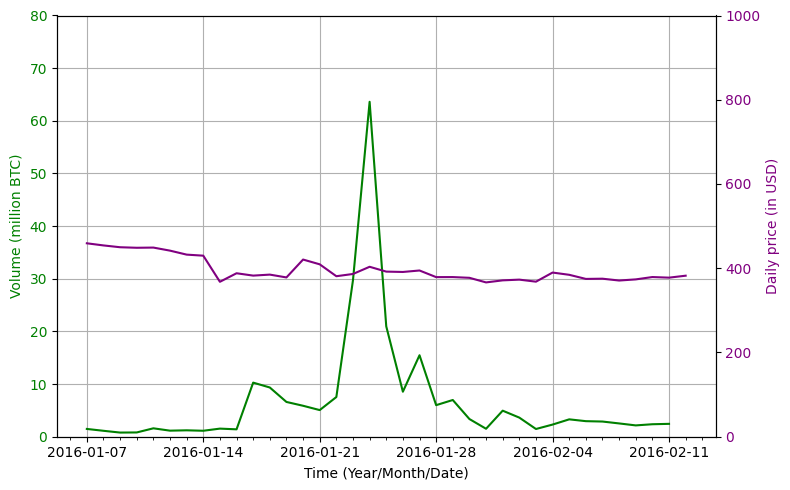

In [19]:
plt.style.use('default')

fig, ax1 = plt.subplots(figsize=(8,5))

color = 'green'
ax1.set_xlabel('Time (Year/Month/Date)')
ax1.set_ylabel('Volume (million BTC)', color=color)
ax1.plot(global_data_january['date'], global_data_january['volume_without_self'] / 100000000000000, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)
ax1.set_ylim(ymin=0, ymax=80)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax1.xaxis.set_minor_locator(mdates.DayLocator())

ax2 = ax1.twinx()
color = 'purple'
ax2.set_ylabel('Daily price (in USD)', color=color)
ax2.plot(external_data_january['date'], external_data_january['PriceUSD'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(ymin=0, ymax=1000)

fig.tight_layout()

Le graphique ci-dessus confirme l'existence de l'anomalie. Nous pouvons clairement observer un pic représentant cette anomalie à la dernière semaine du mois de janvier 2016.

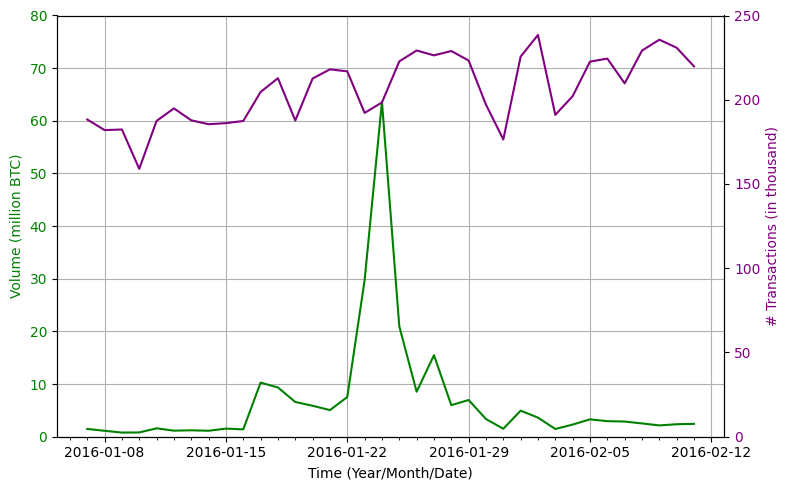

In [20]:
plt.style.use('default')

fig, ax1 = plt.subplots(figsize=(8,5))

color = 'green'
ax1.set_xlabel('Time (Year/Month/Date)')
ax1.set_ylabel('Volume (million BTC)', color=color)
ax1.plot(global_data_january['date'], global_data_january['volume_without_self'] / 100000000000000, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)
ax1.set_ylim(ymin=0, ymax=80)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax1.xaxis.set_minor_locator(mdates.DayLocator())

ax2 = ax1.twinx()
color = 'purple'
ax2.set_ylabel('# Transactions (in thousand)', color=color)
ax2.plot(global_data_january['date'], global_data_january['nb_transactions'] / 1000, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(ymin=0, ymax=250)

fig.tight_layout()

En observant le nombre de transactions, nous remarquons qu'en janvier, elles sont restées dans une fourchette de 0,18 à 0,24 million, tandis que le volume a été multiplié par plus de 100. Cette observation indique qu'il y avait un volume important de bitcoins circulant sur un groupe particulier de portefeuilles, car le nombre total de transactions quotidiennes est resté dans la fourchette normale.

Nous allons maintenant extraire uniquement les données des 7 jours pendant lesquels le pic a été enregistré, soit du 21 au 27 janvier 2016.

In [21]:
data21 = pd.read_csv('DefiEGC2024/networks/2016-1-21.csv')
data22 = pd.read_csv('DefiEGC2024/networks/2016-1-22.csv')
data23 = pd.read_csv('DefiEGC2024/networks/2016-1-23.csv')
data24 = pd.read_csv('DefiEGC2024/networks/2016-1-24.csv')
data25 = pd.read_csv('DefiEGC2024/networks/2016-1-25.csv')
data26 = pd.read_csv('DefiEGC2024/networks/2016-1-26.csv')
data27 = pd.read_csv('DefiEGC2024/networks/2016-1-27.csv')

week_data = pd.concat([data21, data22, data23, data24, data25, data26, data27], axis=0)
week_data = week_data.sort_values('value', ascending=False)
week_data = week_data.reset_index()
week_data = week_data.drop('index', axis=1)

week_data

,Source,Target,value,nb_transactions
0,ePay.info_CoinJoinMess,424,75948861593964,786
1,ePay.info_CoinJoinMess,424,75424051361775,783
2,ePay.info_CoinJoinMess,424,75193512556368,794
3,ePay.info_CoinJoinMess,424,72963965411220,780
4,ePay.info_CoinJoinMess,Huobi.com,72207713283905,762
...,...,...,...,...
51004,24438,20042,5860,1
51005,16621,170,5248,1
51006,7328,Xapo.com,5000,1
51007,71632776,34698,2749,1


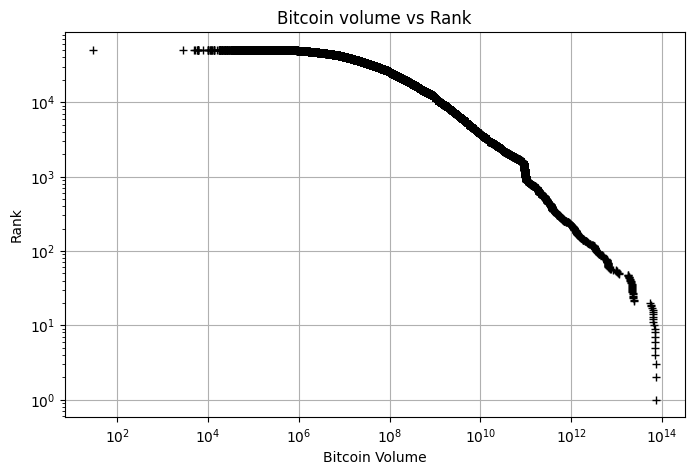

In [22]:
plt.figure(figsize=(8,5))

plt.loglog(week_data['value'], week_data.index, '+', color='black')

plt.title('Bitcoin volume vs Rank')
plt.xlabel('Bitcoin Volume')
plt.ylabel('Rank')

plt.grid(True)

plt.show()

Pour mieux identifier l'anomalie, nous avons classé les transactions par volume. Sur le graphique obtenu, nous pouvons observer un nombre considérable de transactions ayant des petits rangs à la queue de la distribution. De plus, la forme irrégulière de la queue suggérait que ces transactions étaient regroupées. Il y a donc bien un petit groupe de transactions contenant un volume très élevé de bitcoins.

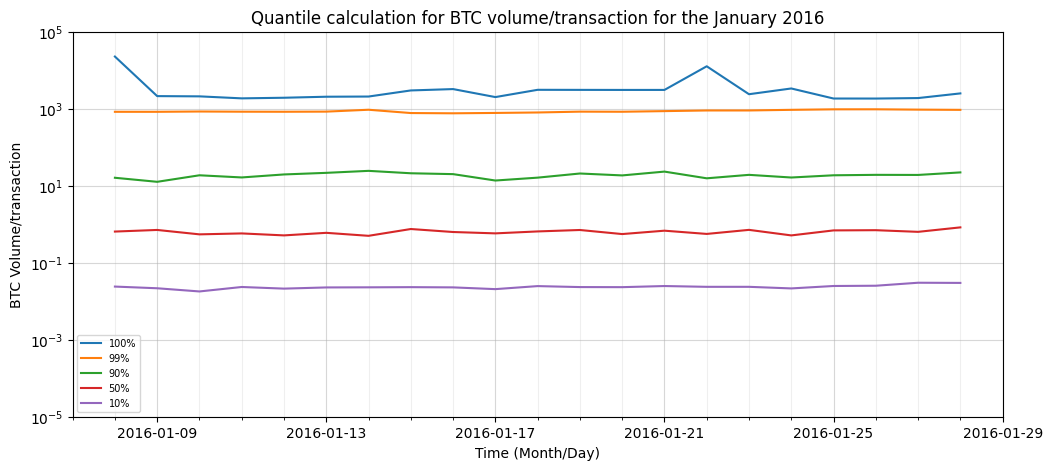

In [23]:
day = 8
quantiles = pd.DataFrame(columns=['date', '10%', '50%', '90%', '99%', '100%',])
i = 0
while (day <= 28):
    data = pd.read_csv('DefiEGC2024/networks/2016-1-' + str(day) + '.csv')
    # extract volume/transaction
    volume_per_transaction = (data.value / 100000000) / data.nb_transactions
    quantiles.loc[i] = ['2016-1-' + str(day),
                         volume_per_transaction.quantile(0.10),
                         volume_per_transaction.quantile(0.50),
                         volume_per_transaction.quantile(0.90),
                         volume_per_transaction.quantile(0.99),
                         volume_per_transaction.quantile(1.0),]
    day += 1
    i += 1
quantiles["date"] = pd.to_datetime(quantiles["date"])

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(quantiles['date'], quantiles['100%'], label='100%')
ax.plot(quantiles['date'], quantiles['99%'], label='99%')
ax.plot(quantiles['date'], quantiles['90%'], label='90%')
ax.plot(quantiles['date'], quantiles['50%'], label='50%')
ax.plot(quantiles['date'], quantiles['10%'], label='10%')

plt.yscale('log')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
ax.xaxis.set_minor_locator(mdates.DayLocator())

ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

ax.set_ylim(ymin=0.00001, ymax=100000)
ax.set_xlabel('Time (Month/Day)')
ax.set_ylabel('BTC Volume/transaction')
ax.set_title('Quantile calculation for BTC volume/transaction for the January 2016')
ax.legend(fontsize=7, loc='lower left')

plt.show()

Nous avons ensuite tracé les quantiles pour mieux observer cette anomalie. Les quantiles sont une mesure statistique qui permet de diviser un ensemble de données en sous-groupes égaux. Ils sont souvent utilisés pour décrire la distribution des données et pour identifier les valeurs extrêmes ou aberrantes.

La distance entre la courbe bleue et la courbe rouge représente ici 1% du volume par transaction. On observe une forte augmentation de cette distance le 22 janvier 2016, correspondant à l'anomalie qui a créé le pic de volume.

Cela conduit à une explication possible des événements historiques, à savoir le soft fork de l'amélioration de Bitcoin et la mise à niveau du protocole appelée BIP-144 qui se sont déroulés pendant cette période. Ces transactions aberrantes pourraient être le résultat de l'expérimentation des développeurs de bitcoin.

### Anomalies dans le graphe orienté des transactions

Nous allons maintenant étudier cette même période de 4 jours présentant un pic de volume anormalement élevé grâce au graphe orienté des transactions.

In [24]:
# get data about transactions from 21st to 24th January 2016
data21 = pd.read_csv('DefiEGC2024/networks/2016-1-21.csv')
data22 = pd.read_csv('DefiEGC2024/networks/2016-1-22.csv')
data23 = pd.read_csv('DefiEGC2024/networks/2016-1-23.csv')
data24 = pd.read_csv('DefiEGC2024/networks/2016-1-24.csv')

df = pd.concat([data21, data22, data23, data24], axis=0)

df

,Source,Target,value,nb_transactions
0,Xapo.com,24179,2020749278,2
1,47654,269,11000024,1
2,CoinPayments.net,72025812,4660114,1
3,855,HaoBTC.com,12200264,1
4,6882,883,1500888000,1
...,...,...,...,...
6458,69278079,72865517,49931146,1
6459,2990531,73126948,2166322,1
6460,70953422,227,5049000,1
6461,Xapo.com,131,4565200796,1


In [25]:
# create new dataframe
actors = pd.concat([df['Source'], df['Target']]).unique()
new_df = pd.DataFrame({'actor': actors})

# nb of input transactions for each actor
indeg_df = df.groupby('Target').agg({'nb_transactions': 'sum'})
indeg_df = indeg_df.reset_index().rename(columns={'Target': 'actor', 'nb_transactions': 'indeg'})
new_df = new_df.merge(indeg_df, on='actor', how='left').fillna(0)

# nb of output transactions for each actor
outdeg_df = df.groupby('Source').agg({'nb_transactions': 'sum'})
outdeg_df = outdeg_df.reset_index().rename(columns={'Source': 'actor', 'nb_transactions': 'outdeg'})
new_df = new_df.merge(outdeg_df, on='actor', how='left').fillna(0)

# create pivot table
pivot_df = new_df.pivot_table(index='indeg', columns='outdeg', values='actor', aggfunc='count', fill_value=0)

# adding one for log norm
pivot_df += 1

pivot_df


outdeg,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,2424.0,3425.0,4128.0,5300.0,6524.0,10199.0,12762.0,17846.0,19351.0,33489.0
indeg,,,,,,,,,,,,,,,,,,,,,
0.0,1,649,322,177,112,60,54,34,23,19,...,1,1,1,1,1,1,1,1,1,1
1.0,730,240,129,70,51,28,29,17,12,8,...,1,1,1,1,1,1,1,1,1,1
2.0,297,125,75,50,26,30,10,13,8,11,...,1,1,1,1,1,1,1,1,1,1
3.0,141,69,49,32,31,27,10,11,5,7,...,1,1,1,1,1,1,1,1,1,1
4.0,78,50,50,29,28,12,19,7,8,7,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5768.0,2,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6101.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,2,1
7592.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


Une fois les données traitées, nous pouvons créer une matrice de corrélation. Cette matrice nous permettra de décrire visuellement les propriétés importantes du réseau représentant les différentes interactions entre les acteurs. Il est également à noter que nous étudions ici les données des 10 000 acteurs les plus actifs, et non pas de tous les acteurs.

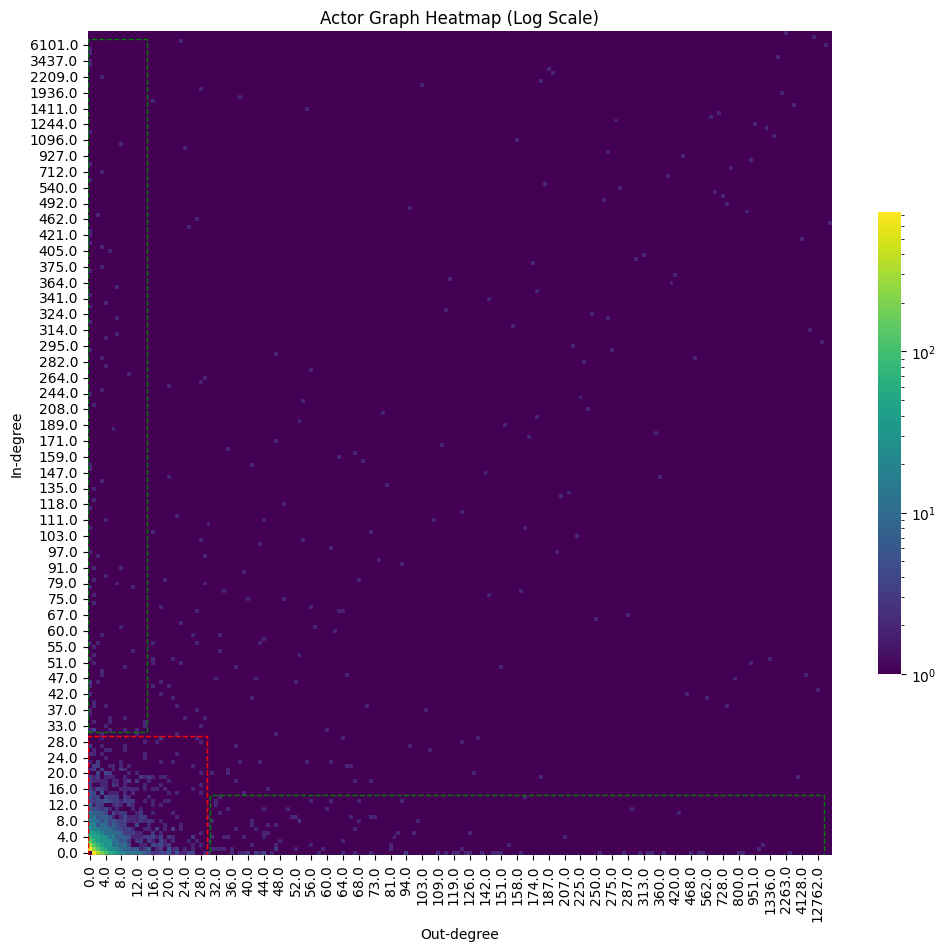

In [26]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(pivot_df, square=True, linewidths=0, cmap='viridis', cbar_kws={'shrink': 0.5}, norm=(LogNorm()))
ax.invert_yaxis() # invert y-axis
plt.xlabel('Out-degree')
plt.ylabel('In-degree')
plt.title('Actor Graph Heatmap (Log Scale)')

# adding red square
rect = plt.Rectangle((0, 0), 30, 30, fill=False, edgecolor='red', lw=1, linestyle='dashed')
ax.add_patch(rect)
# adding green squares
rect = plt.Rectangle((31, 0), 155, 15, fill=False, edgecolor='green', lw=1, linestyle='dashed')
ax.add_patch(rect)
rect = plt.Rectangle((0, 31), 15, 175, fill=False, edgecolor='green', lw=1, linestyle='dashed')
ax.add_patch(rect)


plt.show()

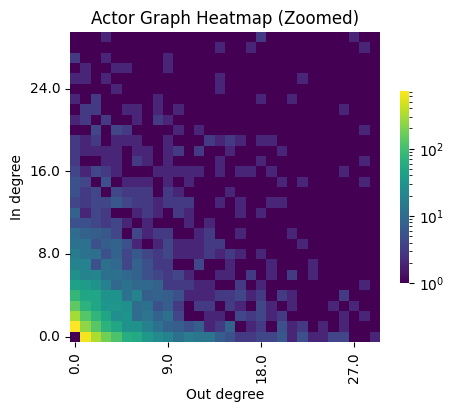

In [27]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(pivot_df, square=True, linewidths=0, cmap='viridis', cbar_kws={'shrink': 0.5}, norm=(LogNorm()))
ax.invert_yaxis() # invert y-axis
ax.set_xlim(xmin=0, xmax=30)
ax.set_ylim(ymin=0, ymax=30)
plt.xlabel('Out degree')
plt.ylabel('In degree')
plt.title('Actor Graph Heatmap (Zoomed)')
plt.show()

Lorsque nous affichons le heatmap des transactions, nous remarquons immédiatement les acteurs présentant des anomalies. Dans les zones vertes, ce sont les acteurs qui reçoivent ou émettent un nombre de transactions beaucoup trop élevé. Dans la grande zone en dehors des pointillés, ce sont tous les autres acteurs qui effectuent un nombre anormalement élevé de transactions.

Quant au carré rouge, il représente tous les autres acteurs de la blockchain ayant un nombre de transactions normal. Nous l'avons agrandi sur le deuxième heatmap pour une meilleure visibilité.

Pour aller encore plus loin, on pourrait identifier les adresses de ces acteurs afin d'avoir plus d'explications sur ces anomalies.

### Conclusion

En conclusion, notre étude a permis de reproduire et d'améliorer les méthodes d'analyse des transactions de la blockchain du Bitcoin, basées sur l'article de recherche. Nous avons pu visualiser les motifs temporels des transactions et analyser statistiquement les données pour identifier les anomalies.

Notre analyse a mis en évidence un certain nombre de conclusions importantes. Tout d'abord, nous avons observé que le rendement logarithmique et la fonction d'auto-corrélation sont des outils utiles pour comprendre les tendances et les motifs de corrélation dans les données de la blockchain. Ensuite, nous avons constaté que l'évolution générale du Bitcoin présente des tendances à long terme, avec des périodes de croissance exponentielle et de fluctuations significatives.

En examinant les patterns hebdomadaires du volume et des transactions de BTC, nous avons identifié un schéma clair avec une plus grande activité en semaine par rapport au week-end, ce qui indique une variation hebdomadaire dans le comportement des transactions. De plus, nous avons détecté des anomalies dans les patterns des transactions, suggérant la présence d'événements historiques ou de comportements inhabituels dans la blockchain.

Enfin, nous avons également identifié des anomalies dans le graphe orienté des transactions, mettant en évidence des connexions inhabituelles ou des comportements atypiques entre les adresses de la blockchain.

Ces résultats soulignent l'importance d'une analyse approfondie des données de la blockchain pour détecter les anomalies et comprendre les tendances et les comportements des transactions de la cryptomonnaie. 